In [1]:
# Cell 1: Imports
# Basic OS, date/time, and numerical libraries
import os
from datetime import datetime
import numpy as np

# Libraries for data handling and scientific computing
import xarray as xr
import dask.array as da # For handling large arrays that don't fit in memory

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F # For functions like F.pad
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning for streamlining training
import lightning.pytorch as pl

# Plotting library
import matplotlib.pyplot as plt

# Pandas for data manipulation (e.g., creating submission CSV)
import pandas as pd


In [2]:
# Cell 2: Configuration
# Main configuration dictionary for the experiment

# NOTE: You MUST change the 'path' in config['data'] to the correct location 
# of your 'processed_data_cse151b_v2_corrupted_ssp245.zarr' file.
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"], # Input climate forcing variables
        "output_vars": ["tas", "pr"], # Target variables: surface air temperature and precipitation
        "target_member_id": 0, # Ensemble member to use for target variables
        "train_ssps": ["ssp126", "ssp370", "ssp585"], # SSP scenarios for training
        "test_ssp": "ssp245",  # SSP scenario for testing (held-out)
        "test_months": 120,   # Number of months for the test split (last 10 years)
        "batch_size": 64,     # Batch size for training and evaluation
        "num_workers": 4,     # Number of workers for DataLoader
    },
    "model_unet": { # Configuration specific to U-Net
        "type": "unet",
        "init_features": 64, # Number of features in the first convolutional layer of U-Net
        "bilinear": True,    # Whether to use bilinear upsampling in U-Net's decoder
    },
    "training": {
        "lr": 1e-3, # Learning rate
        # Add other training parameters like weight_decay if needed
    },
    "trainer": {
        "max_epochs": 20,         # Maximum number of training epochs
        "accelerator": "auto",    # Auto-detect accelerator (CPU, GPU, TPU)
        "devices": "auto",        # Auto-detect number of devices
        "precision": 32,          # Training precision (e.g., 16 for mixed-precision)
        "deterministic": True,    # For reproducibility
        "num_sanity_val_steps": 0,# Number of sanity check validation steps before training
        # "logger": True, # Example: WandbLogger(...) or TensorBoardLogger(...)
        # "callbacks": [] # Example: [ModelCheckpoint(...), EarlyStopping(...)]
    },
    "seed": 42, # Seed for reproducibility
}

# Set seed for PyTorch Lightning, PyTorch, NumPy, and Python's random module
pl.seed_everything(config["seed"], workers=True) 

# Suggestion from PyTorch for Tensor Core utilization on compatible GPUs
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7: # Check for Volta architecture or newer
    torch.set_float32_matmul_precision('medium') # or 'high'
    print("Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.")


Seed set to 42


Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.


In [3]:
# Cell 3: Latitude Weights Utility

def get_lat_weights(latitude_values):
    """
    Computes cosine-based area weights for each latitude.
    This accounts for the Earth's curvature, giving more weight to
    grid cells near the equator for global metrics.

    Args:
        latitude_values (np.array): Array of latitude values in degrees.

    Returns:
        np.array: Normalized latitude weights.
    """
    lat_rad = np.deg2rad(latitude_values) # Convert degrees to radians
    weights = np.cos(lat_rad)             # Cosine of latitude
    return weights / np.mean(weights)     # Normalize by the mean weight


In [4]:
# Cell 4: Normalizer Class

class Normalizer:
    """
    Handles Z-score normalization for input and output data.
    (data - mean) / std
    """
    def __init__(self):
        self.mean_in, self.std_in = None, None   # Statistics for input data
        self.mean_out, self.std_out = None, None # Statistics for output data

    def set_input_statistics(self, mean, std):
        """Sets the mean and standard deviation for input data."""
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        """Sets the mean and standard deviation for output data."""
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        """
        Normalizes the data using pre-computed statistics.

        Args:
            data (np.array or dask.array): Data to normalize.
            data_type (str): "input" or "output", to use appropriate statistics.

        Returns:
            Normalized data.
        
        Raises:
            ValueError: If statistics for the specified data_type are not set.
        """
        if data_type == "input":
            if self.mean_in is None or self.std_in is None:
                raise ValueError("Input statistics not set in Normalizer.")
            # Add a small epsilon to std to prevent division by zero if std is very small or zero
            return (data - self.mean_in) / (self.std_in + 1e-8) 
        elif data_type == "output":
            if self.mean_out is None or self.std_out is None:
                raise ValueError("Output statistics not set in Normalizer.")
            return (data - self.mean_out) / (self.std_out + 1e-8)
        else:
            raise ValueError(f"Invalid data_type '{data_type}'. Must be 'input' or 'output'.")

    def inverse_transform_output(self, data):
        """
        Applies inverse normalization to output data (predictions).

        Args:
            data (torch.Tensor or np.array): Normalized output data.

        Returns:
            Data in original physical units.

        Raises:
            ValueError: If output statistics are not set.
        """
        if self.mean_out is None or self.std_out is None:
            raise ValueError("Output statistics not set in Normalizer for inverse transform.")
        return data * (self.std_out + 1e-8) + self.mean_out


In [5]:
# Cell 5: U-Net Model Architecture
# (DoubleConv, Down, Up, OutConv, UNet classes)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels_x1, in_channels_x2, out_channels, bilinear=True):
        super().__init__()
        # in_channels_x1: channels of the feature map from the upsampling path (lower layer in decoder)
        # in_channels_x2: channels of the feature map from the skip connection (encoder)
        # out_channels: channels produced by this Up block

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # After upsampling x1, its channel count (in_channels_x1) remains the same.
            # It's then concatenated with x2 (in_channels_x2).
            # So, the input to DoubleConv is (in_channels_x1 + in_channels_x2).
            self.conv = DoubleConv(in_channels_x1 + in_channels_x2, out_channels)
        else:
            # ConvTranspose2d halves the channels of x1 (in_channels_x1 -> in_channels_x1 // 2)
            self.up = nn.ConvTranspose2d(in_channels_x1, in_channels_x1 // 2, kernel_size=2, stride=2)
            # Input to DoubleConv is (in_channels_x1 // 2 + in_channels_x2)
            self.conv = DoubleConv(in_channels_x1 // 2 + in_channels_x2, out_channels)


    def forward(self, x1, x2):
        # x1: feature map from upsampling path (e.g., from x_bottleneck or previous Up layer)
        # x2: feature map from skip connection (encoder path, e.g., x4_skip)
        x1 = self.up(x1)
        
        # Pad x1 to match x2's spatial dimensions if they differ
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1) # Concatenate along channel dimension
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, bilinear=True, init_features=64):
        super(UNet, self).__init__()
        self.n_input_channels = n_input_channels
        self.n_output_channels = n_output_channels
        self.bilinear = bilinear
        self.init_features = init_features 
        
        f = init_features # Short alias

        # Encoder
        self.inc = DoubleConv(n_input_channels, f)
        self.down1 = Down(f, f * 2)
        self.down2 = Down(f * 2, f * 4)
        self.down3 = Down(f * 4, f * 8)
        self.down4 = Down(f * 8, f * 16) # Bottleneck input features

        # Decoder
        # Arguments for Up: (channels_from_lower_upsampled_layer, channels_from_skip_connection, output_channels_for_this_Up_block)
        self.up1 = Up(f * 16, f * 8,  f * 8, bilinear)
        self.up2 = Up(f * 8,  f * 4,  f * 4, bilinear)
        self.up3 = Up(f * 4,  f * 2,  f * 2, bilinear)
        self.up4 = Up(f * 2,  f,      f,     bilinear)
        
        self.outc = OutConv(f, n_output_channels)

    def forward(self, x):
        x1_skip = self.inc(x)           # -> f
        x2_skip = self.down1(x1_skip)   # -> f * 2
        x3_skip = self.down2(x2_skip)   # -> f * 4
        x4_skip = self.down3(x3_skip)   # -> f * 8
        x_bottleneck = self.down4(x4_skip) # -> f * 16

        # Decoder
        x = self.up1(x_bottleneck, x4_skip) # x_bottleneck (f*16), x4_skip (f*8). Up outputs f*8
        x = self.up2(x, x3_skip)            # x (f*8), x3_skip (f*4). Up outputs f*4
        x = self.up3(x, x2_skip)            # x (f*4), x2_skip (f*2). Up outputs f*2
        x = self.up4(x, x1_skip)            # x (f*2), x1_skip (f). Up outputs f
        
        logits = self.outc(x)
        return logits


In [6]:
# Cell 6: ClimateDataset and ClimateDataModule

class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        """
        PyTorch Dataset for climate data.

        Args:
            inputs_dask (dask.array): Dask array of input features.
            outputs_dask (dask.array): Dask array of output targets.
            output_is_normalized (bool): Flag indicating if outputs_dask is already normalized.
                                         Used for the test set where targets are not pre-normalized.
        """
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any():
            raise ValueError("NaNs found in input dataset after converting to tensor.")
        if torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in output dataset after converting to tensor.")
        
        print(f"Dataset created. Input shape: {self.inputs.shape}, Output shape: {self.outputs.shape}")


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42, 
    ):
        super().__init__()
        self.save_hyperparameters() 
        self.normalizer = Normalizer()

    def prepare_data(self):
        if not os.path.exists(self.hparams.path):
            raise FileNotFoundError(f"Data path not found: {self.hparams.path}. Please check config['data']['path'].")

    def setup(self, stage=None):
        ds = xr.open_zarr(self.hparams.path, consolidated=False, chunks={"time": 24})
        
        # --- FIX for spatial_template ---
        # The 'rsdt' variable might not have 'member_id'. Handle this conditionally.
        rsdt_var_for_template = ds["rsdt"]
        if "member_id" in rsdt_var_for_template.dims:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, member_id=0, drop=True)
        else:
            # If 'member_id' is not present, select without it.
            # This assumes 'rsdt' is consistent across members or doesn't have that dimension.
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, drop=True)
        # --- END FIX ---

        def load_ssp(ssp_name):
            input_dask_list, output_dask_list = [], []
            
            for var_name in self.hparams.input_vars:
                da_var = ds[var_name].sel(ssp=ssp_name)
                if "latitude" in da_var.dims: 
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                # For input variables, if member_id exists, select the target_member_id.
                # If it doesn't exist (e.g. for some forcing data), this sel will be a no-op if strict=False,
                # or we can check existence. Xarray's sel is usually robust if the dim doesn't exist.
                # However, to be safe, let's check.
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.hparams.target_member_id)
                
                if set(da_var.dims) == {"time"}: 
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)
            
            for var_name in self.hparams.output_vars:
                # Output variables are always selected by target_member_id
                da_out = ds[var_name].sel(ssp=ssp_name, member_id=self.hparams.target_member_id)
                if "latitude" in da_out.dims: 
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out.data)

            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_list, train_output_list = [], []
        val_input_ssp370, val_output_ssp370 = None, None

        for ssp in self.hparams.train_ssps:
            x_ssp, y_ssp = load_ssp(ssp)
            if ssp == "ssp370": 
                val_input_ssp370 = x_ssp[-self.hparams.test_months:]
                val_output_ssp370 = y_ssp[-self.hparams.test_months:]
                train_input_list.append(x_ssp[:-self.hparams.test_months])
                train_output_list.append(y_ssp[:-self.hparams.test_months])
            else:
                train_input_list.append(x_ssp)
                train_output_list.append(y_ssp)
        
        train_input_all_ssp = da.concatenate(train_input_list, axis=0)
        train_output_all_ssp = da.concatenate(train_output_list, axis=0)

        input_mean = da.nanmean(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.nanstd(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)

        output_mean = da.nanmean(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.nanstd(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm = self.normalizer.normalize(train_input_all_ssp, "input")
        train_output_norm = self.normalizer.normalize(train_output_all_ssp, "output")
        
        val_input_norm = self.normalizer.normalize(val_input_ssp370, "input")
        val_output_norm = self.normalizer.normalize(val_output_ssp370, "output")

        test_input_ssp, test_output_ssp = load_ssp(self.hparams.test_ssp)
        test_input_ssp = test_input_ssp[-self.hparams.test_months:] 
        test_output_ssp = test_output_ssp[-self.hparams.test_months:]
        test_input_norm = self.normalizer.normalize(test_input_ssp, "input")

        if stage == "fit" or stage is None:
            self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
            self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        if stage == "test" or stage is None:
            self.test_dataset = ClimateDataset(test_input_norm, test_output_ssp, output_is_normalized=False)
        
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

        ds.close()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon


In [7]:
# Cell 7: ClimateEmulationModule (PyTorch Lightning)

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model 
        self.save_hyperparameters(ignore=['model']) 
        
        self.criterion = nn.MSELoss() 
        self.normalizer = None 
        
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def _get_normalizer_from_datamodule(self):
        """Helper to safely get normalizer from datamodule."""
        if hasattr(self.trainer, 'datamodule') and self.trainer.datamodule is not None and hasattr(self.trainer.datamodule, 'normalizer'):
            return self.trainer.datamodule.normalizer
        else:
            # Fallback if trainer.datamodule is not set up (e.g. direct call to test without fit)
            # This requires 'config' to be globally accessible or passed differently.
            print("Warning: Normalizer not found via self.trainer.datamodule. Attempting fallback initialization.")
            temp_dm = ClimateDataModule(**config["data"]) 
            temp_dm.prepare_data()
            temp_dm.setup(stage="test") # Or appropriate stage to ensure normalizer stats are computed
            return temp_dm.normalizer


    def on_fit_start(self):
        """Called at the beginning of training."""
        self.normalizer = self._get_normalizer_from_datamodule()

    def on_test_start(self):
        """Called at the beginning of testing."""
        if self.normalizer is None: # Ensure normalizer is available
            self.normalizer = self._get_normalizer_from_datamodule()


    def training_step(self, batch, batch_idx):
        x, y_norm = batch 
        y_hat_norm = self(x)   
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_norm = batch
        y_hat_norm = self(x)
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        y_denorm = self.normalizer.inverse_transform_output(y_norm.detach().cpu().numpy())
        
        self.val_preds.append(y_hat_denorm)
        self.val_targets.append(y_denorm)
        return loss 

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: # Skip during sanity check
            if not self.val_preds or not self.val_targets: 
                return

            preds_epoch = np.concatenate(self.val_preds, axis=0)
            trues_epoch = np.concatenate(self.val_targets, axis=0)
            
            if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
            
            self._evaluate(preds_epoch, trues_epoch, phase="val")
            
            np.save("val_preds.npy", preds_epoch)
            np.save("val_trues.npy", trues_epoch)
            
            self.val_preds.clear() 
            self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y_true_denorm = batch 
        y_hat_norm = self(x)    

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
        
        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        
        self.test_preds.append(y_hat_denorm)
        self.test_targets.append(y_true_denorm.detach().cpu().numpy()) 

    def on_test_epoch_end(self):
        if not self.test_preds or not self.test_targets: 
            return

        preds_epoch = np.concatenate(self.test_preds, axis=0)
        trues_epoch = np.concatenate(self.test_targets, axis=0)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        self._evaluate(preds_epoch, trues_epoch, phase="test")
        self._save_submission(preds_epoch) 
        
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def _evaluate(self, preds_np, trues_np, phase="val"):
        """Calculates and logs evaluation metrics."""
        # This check is important for when _evaluate might be called outside trainer.fit/test context
        # or if datamodule is not correctly propagated.
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_lat_weights'):
            print("Warning: self.trainer.datamodule not fully available in _evaluate. Using fallback for coords/weights.")
            dm_eval = ClimateDataModule(**config["data"]) # Re-init for coords, assumes global config
            dm_eval.prepare_data()
            dm_eval.setup(stage=phase) # Setup for the correct stage
            area_weights = dm_eval.get_lat_weights()
            lat, lon = dm_eval.get_coords()
            output_vars = dm_eval.hparams.output_vars
        else:
            area_weights = self.trainer.datamodule.get_lat_weights()
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars


        time_coords = np.arange(preds_np.shape[0])
        metrics_summary = {}

        for i, var_name in enumerate(output_vars):
            p_var = preds_np[:, i] 
            t_var = trues_np[:, i] 
            
            p_xr = xr.DataArray(p_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})
            t_xr = xr.DataArray(t_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean()).item()
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean()).item()
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean().item()

            print(f"[{phase.upper()}] {var_name}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            
            metrics_summary[f"{phase}/{var_name}/rmse"] = rmse
            metrics_summary[f"{phase}/{var_name}/time_mean_rmse"] = mean_rmse
            metrics_summary[f"{phase}/{var_name}/time_std_mae"] = std_mae
        
        self.log_dict(metrics_summary, logger=True)

    def _save_submission(self, predictions_np):
        """Saves model predictions to a CSV file in Kaggle submission format."""
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_coords'):
            print("Warning: self.trainer.datamodule not fully available in _save_submission. Using fallback.")
            dm_submission = ClimateDataModule(**config["data"])
            dm_submission.prepare_data()
            dm_submission.setup(stage="test") # Ensure coords are loaded
            lat, lon = dm_submission.get_coords()
            output_vars = dm_submission.hparams.output_vars
        else:
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars
            
        time_coords_submission = np.arange(predictions_np.shape[0])

        rows = []
        for t_idx, t_val in enumerate(time_coords_submission):
            for var_idx, var_name in enumerate(output_vars):
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var_name}_{y_val:.2f}_{x_val:.2f}"
                        pred_value = predictions_np[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred_value})

        submission_df = pd.DataFrame(rows)
        submission_dir = "submissions"
        os.makedirs(submission_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filepath = os.path.join(submission_dir, f"kaggle_submission_unet_{timestamp}.csv")
        submission_df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")


In [8]:
# Cell 8: Training and Evaluation Script

# --- Instantiate DataModule ---
datamodule = ClimateDataModule(**config["data"])
# datamodule.prepare_data() # Called by Trainer when .fit() or .test() is called
# datamodule.setup()      # Called by Trainer when .fit() or .test() is called

# --- Instantiate U-Net Model ---
n_inputs = len(config["data"]["input_vars"])
n_outputs = len(config["data"]["output_vars"])

unet_config_params = config.get("model_unet", {}) 
init_features = unet_config_params.get("init_features", 64)
bilinear_upsampling = unet_config_params.get("bilinear", True)

unet_model = UNet(n_input_channels=n_inputs, 
                  n_output_channels=n_outputs, 
                  init_features=init_features,
                  bilinear=bilinear_upsampling)

# --- Instantiate Lightning Module ---
learning_rate = config["training"]["lr"]
lightning_module = ClimateEmulationModule(unet_model, learning_rate=learning_rate)

# --- Setup Trainer ---
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor="val/loss", 
    mode="min",         
    filename="unet-best-{epoch:02d}-{val/loss:.2f}", 
    save_top_k=1,       
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor="val/loss",
    patience=5, 
    verbose=True,
    mode="min"
)

trainer_params = {**config["trainer"]} 
trainer_params["callbacks"] = [checkpoint_callback, early_stop_callback]
# Optional: Add logger
# from lightning.pytorch.loggers import TensorBoardLogger
# logger = TensorBoardLogger("tb_logs", name="unet_climate_emulation")
# trainer_params["logger"] = logger

trainer = pl.Trainer(**trainer_params)

# --- Train the Model ---
print("Starting U-Net model training...")
trainer.fit(lightning_module, datamodule=datamodule)
print("Training finished.")

# --- Test the Model ---
print("Starting U-Net model testing using the best checkpoint...")
# trainer.test will use the checkpoint_callback's best_model_path by default if available
# or you can specify ckpt_path="best"
test_results = trainer.test(lightning_module, datamodule=datamodule, ckpt_path="best") 
print("Testing finished.")
print("Test Results:", test_results)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting U-Net model training...
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])



  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.4 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.544   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.411
Epoch 0, global step 46: 'val/loss' reached 0.41131 (best 0.41131), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=00-val/loss=0.41.ckpt' as top 1


[VAL] tas: RMSE=4.9242, Time-Mean RMSE=3.3147, Time-Stddev MAE=1.3951
[VAL] pr: RMSE=3.0942, Time-Mean RMSE=1.4302, Time-Stddev MAE=1.7080


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.072 >= min_delta = 0.0. New best score: 0.339
Epoch 1, global step 92: 'val/loss' reached 0.33930 (best 0.33930), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=01-val/loss=0.34.ckpt' as top 1


[VAL] tas: RMSE=4.1480, Time-Mean RMSE=2.4466, Time-Stddev MAE=1.2698
[VAL] pr: RMSE=2.8289, Time-Mean RMSE=1.0629, Time-Stddev MAE=1.4826


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.090 >= min_delta = 0.0. New best score: 0.249
Epoch 2, global step 138: 'val/loss' reached 0.24908 (best 0.24908), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=02-val/loss=0.25.ckpt' as top 1


[VAL] tas: RMSE=3.2438, Time-Mean RMSE=2.2213, Time-Stddev MAE=0.8985
[VAL] pr: RMSE=2.4371, Time-Mean RMSE=0.8571, Time-Stddev MAE=1.1212


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.029 >= min_delta = 0.0. New best score: 0.220
Epoch 3, global step 184: 'val/loss' reached 0.21987 (best 0.21987), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=03-val/loss=0.22.ckpt' as top 1


[VAL] tas: RMSE=2.8492, Time-Mean RMSE=2.0517, Time-Stddev MAE=0.7391
[VAL] pr: RMSE=2.2947, Time-Mean RMSE=0.7773, Time-Stddev MAE=0.9232


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.022 >= min_delta = 0.0. New best score: 0.198
Epoch 4, global step 230: 'val/loss' reached 0.19783 (best 0.19783), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=04-val/loss=0.20.ckpt' as top 1


[VAL] tas: RMSE=2.5626, Time-Mean RMSE=1.8202, Time-Stddev MAE=0.6748
[VAL] pr: RMSE=2.1822, Time-Mean RMSE=0.6090, Time-Stddev MAE=0.9695


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 276: 'val/loss' was not in top 1


[VAL] tas: RMSE=2.4039, Time-Mean RMSE=1.7028, Time-Stddev MAE=0.6017
[VAL] pr: RMSE=2.2557, Time-Mean RMSE=0.7858, Time-Stddev MAE=0.9151


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.192
Epoch 6, global step 322: 'val/loss' reached 0.19163 (best 0.19163), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=06-val/loss=0.19.ckpt' as top 1


[VAL] tas: RMSE=2.3947, Time-Mean RMSE=1.7407, Time-Stddev MAE=0.5837
[VAL] pr: RMSE=2.1556, Time-Mean RMSE=0.6035, Time-Stddev MAE=0.8847


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 368: 'val/loss' was not in top 1


[VAL] tas: RMSE=2.3392, Time-Mean RMSE=1.6698, Time-Stddev MAE=0.5722
[VAL] pr: RMSE=2.1733, Time-Mean RMSE=0.6303, Time-Stddev MAE=0.8069


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.186
Epoch 8, global step 414: 'val/loss' reached 0.18618 (best 0.18618), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=08-val/loss=0.19.ckpt' as top 1


[VAL] tas: RMSE=2.2066, Time-Mean RMSE=1.5210, Time-Stddev MAE=0.5580
[VAL] pr: RMSE=2.1264, Time-Mean RMSE=0.5509, Time-Stddev MAE=0.8341


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.181
Epoch 9, global step 460: 'val/loss' reached 0.18084 (best 0.18084), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=09-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=2.2742, Time-Mean RMSE=1.6626, Time-Stddev MAE=0.5297
[VAL] pr: RMSE=2.0963, Time-Mean RMSE=0.4971, Time-Stddev MAE=0.8151


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 506: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.9506, Time-Mean RMSE=3.1732, Time-Stddev MAE=0.9980
[VAL] pr: RMSE=2.9286, Time-Mean RMSE=0.9720, Time-Stddev MAE=1.3560


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.178
Epoch 11, global step 552: 'val/loss' reached 0.17806 (best 0.17806), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=11-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=2.0696, Time-Mean RMSE=1.3843, Time-Stddev MAE=0.5087
[VAL] pr: RMSE=2.0875, Time-Mean RMSE=0.4981, Time-Stddev MAE=0.8302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 598: 'val/loss' was not in top 1


[VAL] tas: RMSE=2.0188, Time-Mean RMSE=1.3753, Time-Stddev MAE=0.4825
[VAL] pr: RMSE=2.0979, Time-Mean RMSE=0.5155, Time-Stddev MAE=0.7870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 644: 'val/loss' was not in top 1


[VAL] tas: RMSE=2.1019, Time-Mean RMSE=1.4546, Time-Stddev MAE=0.4962
[VAL] pr: RMSE=2.1186, Time-Mean RMSE=0.5544, Time-Stddev MAE=0.8278


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.177
Epoch 14, global step 690: 'val/loss' reached 0.17741 (best 0.17741), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=14-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=2.0888, Time-Mean RMSE=1.4860, Time-Stddev MAE=0.4245
[VAL] pr: RMSE=2.0844, Time-Mean RMSE=0.5145, Time-Stddev MAE=0.8066


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.177
Epoch 15, global step 736: 'val/loss' reached 0.17710 (best 0.17710), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=15-val/loss=0.18.ckpt' as top 1


[VAL] tas: RMSE=1.9183, Time-Mean RMSE=1.2282, Time-Stddev MAE=0.4503
[VAL] pr: RMSE=2.0857, Time-Mean RMSE=0.5260, Time-Stddev MAE=0.8380


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.171
Epoch 16, global step 782: 'val/loss' reached 0.17076 (best 0.17076), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=16-val/loss=0.17.ckpt' as top 1


[VAL] tas: RMSE=1.8019, Time-Mean RMSE=1.0889, Time-Stddev MAE=0.4371
[VAL] pr: RMSE=2.0507, Time-Mean RMSE=0.4099, Time-Stddev MAE=0.7988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 828: 'val/loss' was not in top 1


[VAL] tas: RMSE=1.8692, Time-Mean RMSE=1.2131, Time-Stddev MAE=0.4156
[VAL] pr: RMSE=2.0627, Time-Mean RMSE=0.4579, Time-Stddev MAE=0.8049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 874: 'val/loss' was not in top 1


[VAL] tas: RMSE=1.8402, Time-Mean RMSE=1.0959, Time-Stddev MAE=0.4640
[VAL] pr: RMSE=2.0539, Time-Mean RMSE=0.4286, Time-Stddev MAE=0.7970


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.170
Epoch 19, global step 920: 'val/loss' reached 0.17037 (best 0.17037), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=19-val/loss=0.17.ckpt' as top 1


[VAL] tas: RMSE=1.7704, Time-Mean RMSE=1.0800, Time-Stddev MAE=0.4034
[VAL] pr: RMSE=2.0496, Time-Mean RMSE=0.4185, Time-Stddev MAE=0.7989


`Trainer.fit` stopped: `max_epochs=20` reached.


Training finished.
Starting U-Net model testing using the best checkpoint...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=19-val/loss=0.17.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_3/checkpoints/unet-best-epoch=19-val/loss=0.17.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=291.4883, Time-Mean RMSE=291.4493, Time-Stddev MAE=3.5137
[TEST] pr: RMSE=4.2175, Time-Mean RMSE=3.7452, Time-Stddev MAE=1.3878
✅ Submission saved to: submissions/kaggle_submission_unet_20250517_043732.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.217491149902344     │
│  test/pr/time_mean_rmse   │     3.74522066116333      │
│   test/pr/time_std_mae    │    1.3878172636032104     │
│       test/tas/rmse       │       291.48828125        │
│  test/tas/time_mean_rmse  │    291.44927978515625     │
│   test/tas/time_std_mae   │     3.513719081878662     │
└───────────────────────────┴───────────────────────────┘

Testing finished.
Test Results: [{'test/tas/rmse': 291.48828125, 'test/tas/time_mean_rmse': 291.44927978515625, 'test/tas/time_std_mae': 3.513719081878662, 'test/pr/rmse': 4.217491149902344, 'test/pr/time_mean_rmse': 3.74522066116333, 'test/pr/time_std_mae': 1.3878172636032104}]


In [9]:
# Cell 9: Plotting Utilities (Optional)
# Ensure matplotlib, numpy, and xarray are imported (usually in Cell 1)

def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric_val=None, metric_name="Metric"):
    """
    Plots a comparison between ground truth, prediction, and their difference.
    Includes calculation and display of a spatial mean metric (e.g., RMSE).
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
    fig.suptitle(title, fontsize=16) 

    common_min = min(true_xr.min().item(), pred_xr.min().item())
    common_max = max(true_xr.max().item(), pred_xr.max().item())

    true_xr.plot(ax=axs[0], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': true_xr.name or 'Value'})
    axs[0].set_title(f"Ground Truth")

    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': pred_xr.name or 'Value'})
    axs[1].set_title(f"Prediction")

    diff = pred_xr - true_xr
    abs_max_diff = np.max(np.abs(diff.data)) if diff.size > 0 else 0.1 
    
    diff_plot_params = {'cmap': diff_cmap, 'add_colorbar': True, 'cbar_kwargs': {'label': 'Difference'}}
    if abs_max_diff > 0: 
        diff_plot_params['vmin'] = -abs_max_diff
        diff_plot_params['vmax'] = abs_max_diff
        
    diff.plot(ax=axs[2], **diff_plot_params)
    
    title_suffix = ""
    if metric_val is not None:
        title_suffix = f" ({metric_name}: {metric_val:.4f})"
    axs[2].set_title(f"Difference (Pred - Truth){title_suffix}")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



--- Visualizing Validation Predictions for U-Net ---


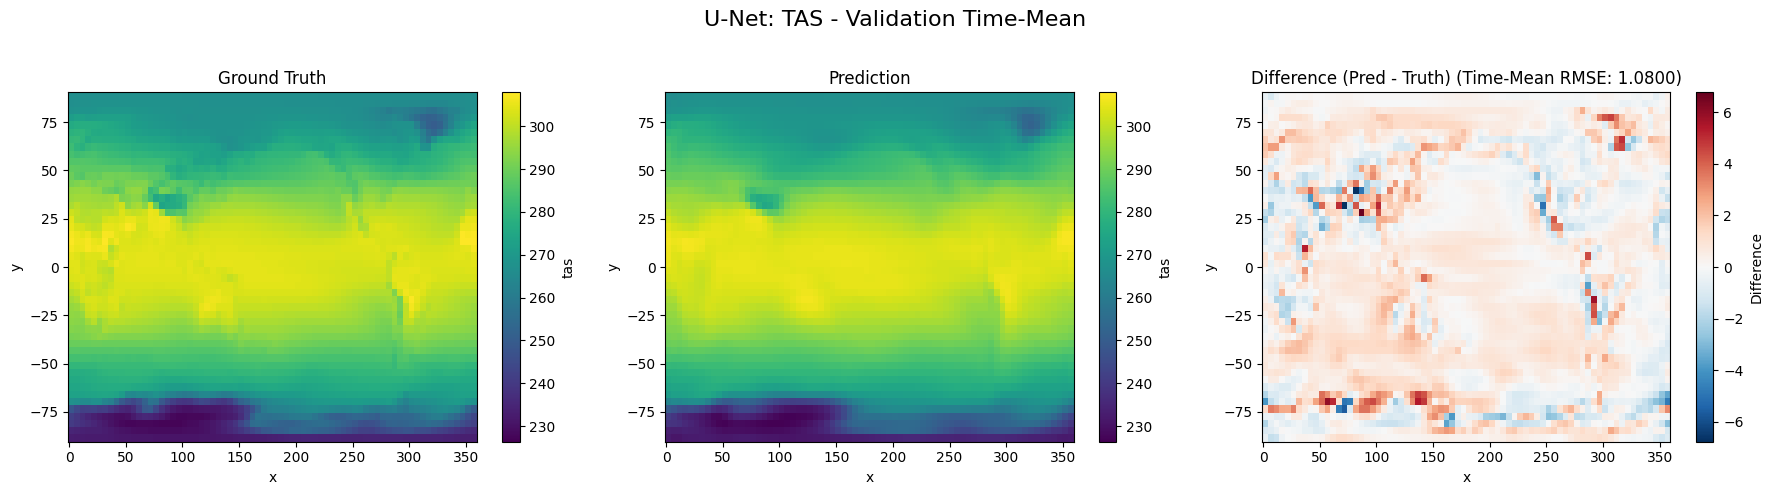

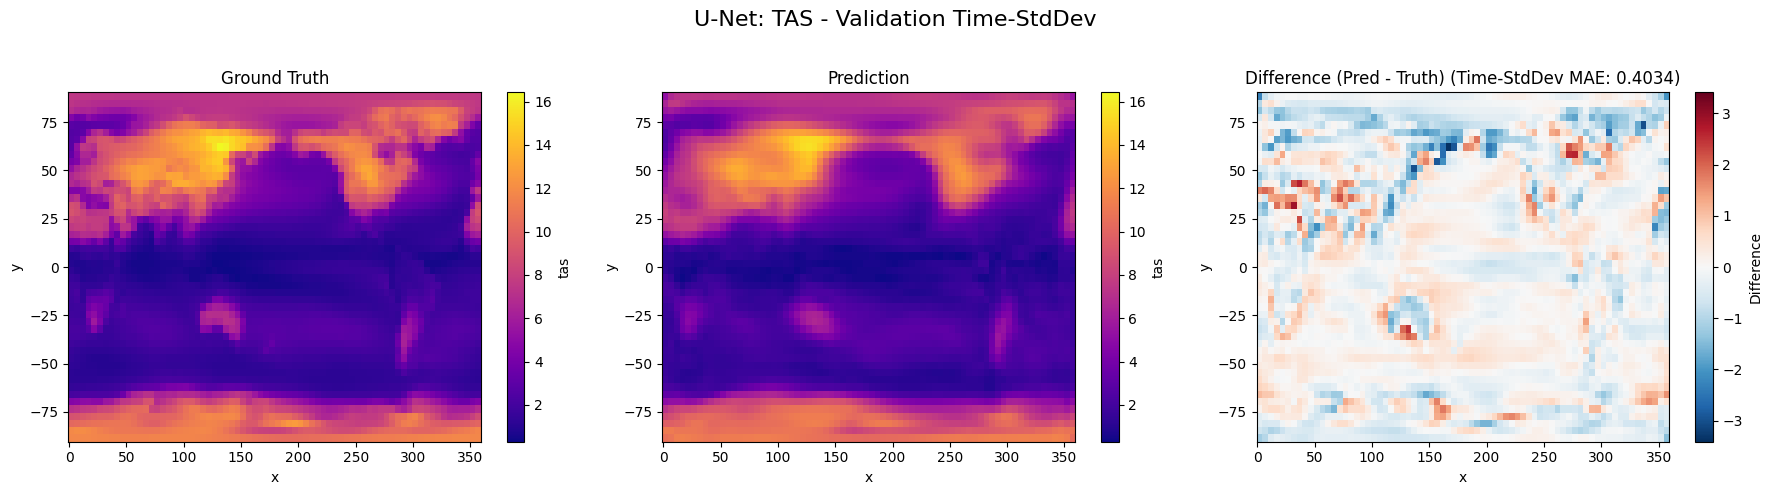

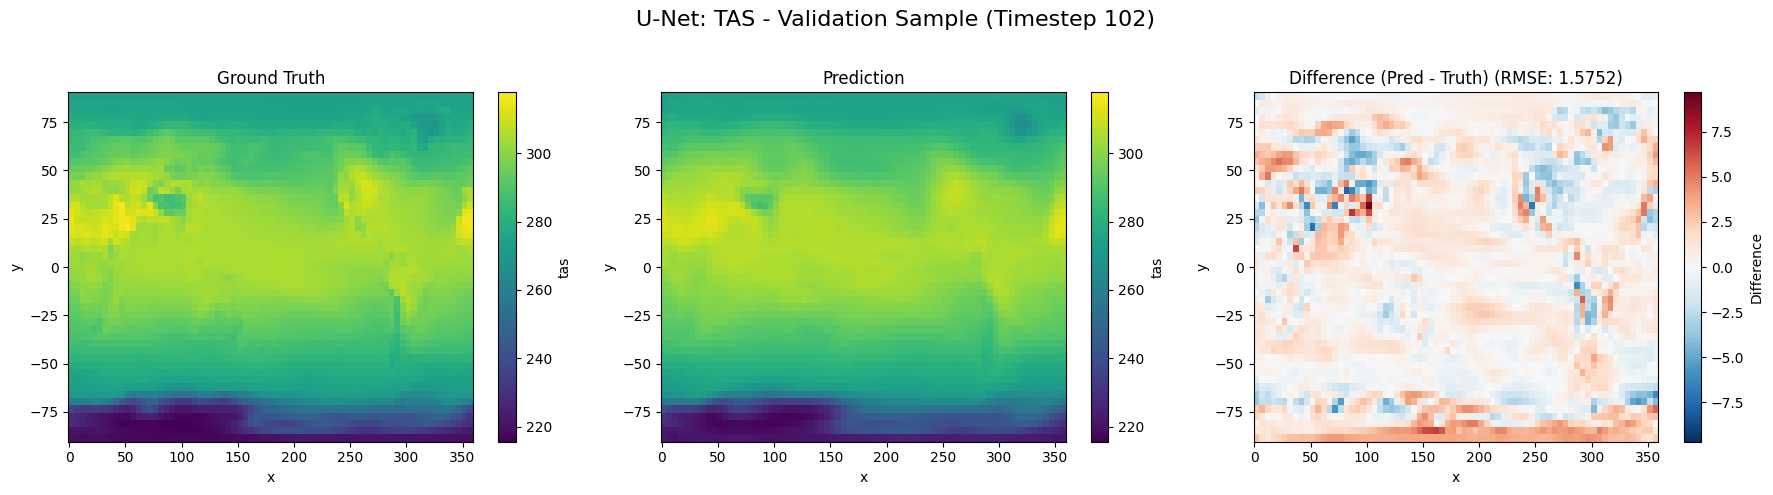

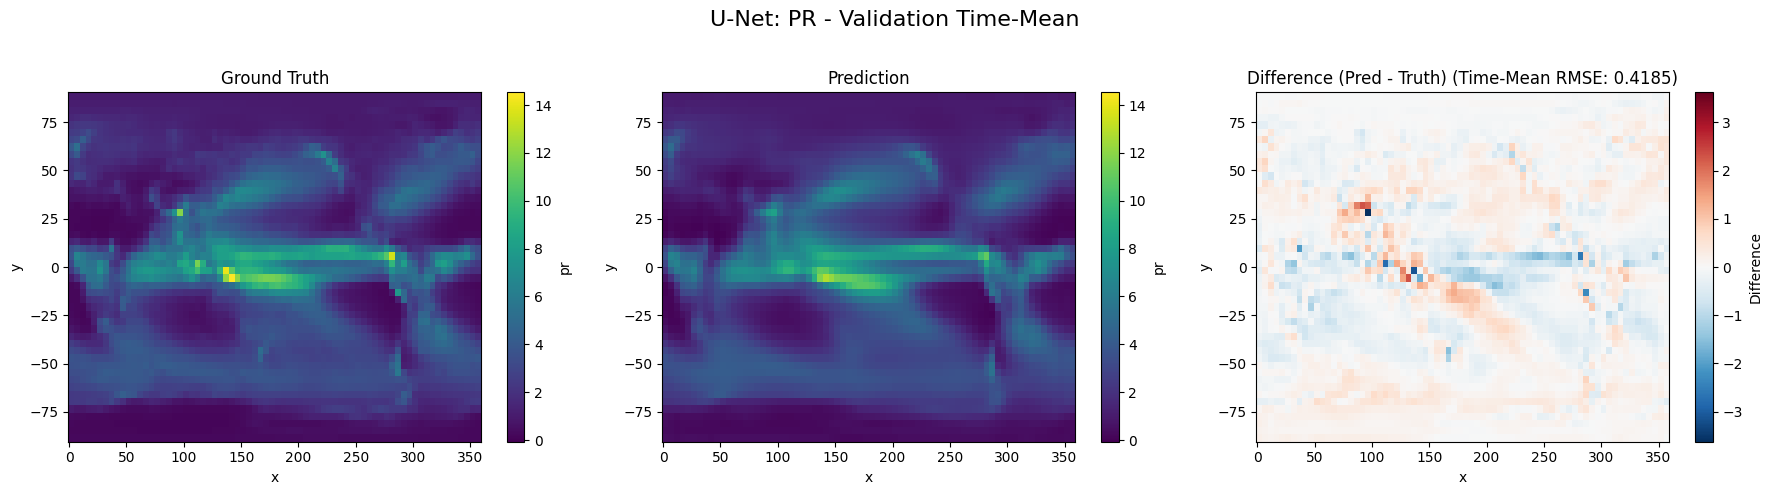

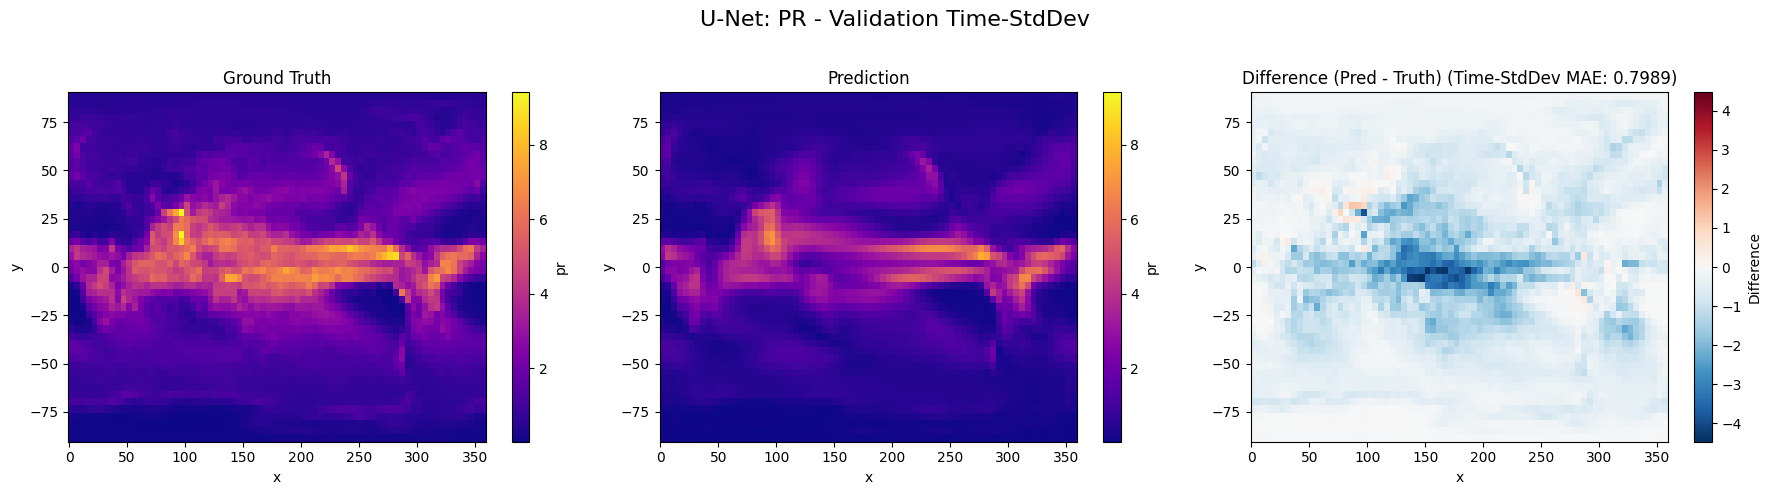

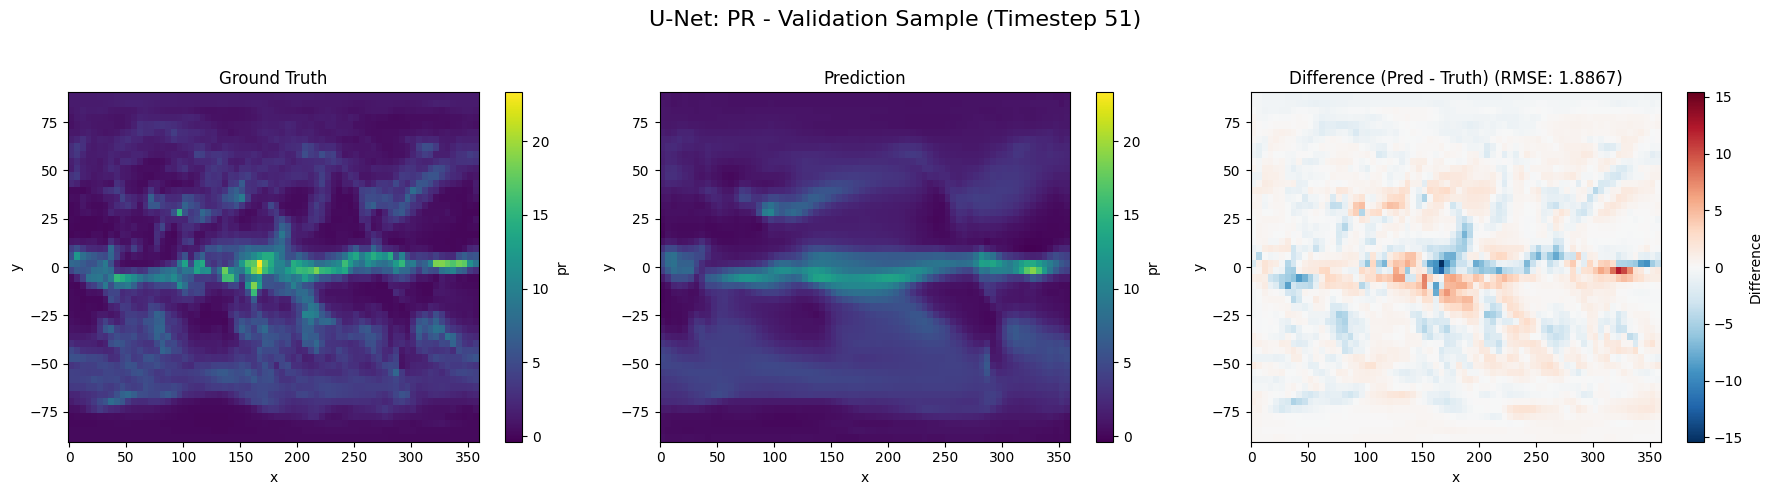

In [10]:
# Cell 10: Visualization Script (Optional)

try:
    val_preds_loaded = np.load("val_preds.npy")
    val_trues_loaded = np.load("val_trues.npy")

    if not hasattr(datamodule, 'lat') or datamodule.lat is None:
        print("Datamodule not fully set up for visualization. Setting it up...")
        # datamodule.prepare_data() # Should have been called by trainer
        datamodule.setup(stage="fit") # Ensure lat, lon, etc. are available

    lat, lon = datamodule.get_coords()
    output_vars = config["data"]["output_vars"] 
    area_weights_vis = datamodule.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded.shape[0])

    print(f"\n--- Visualizing Validation Predictions for U-Net ---")
    for i, var_name in enumerate(output_vars):
        pred_xr = xr.DataArray(val_preds_loaded[:, i], dims=["time", "y", "x"], 
                               coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr = xr.DataArray(val_trues_loaded[:, i], dims=["time", "y", "x"], 
                               coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean = pred_xr.mean("time")
        true_mean = true_xr.mean("time")
        mean_rmse_var = np.sqrt(((pred_mean - true_mean) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean, pred_mean, 
                        f"U-Net: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var, metric_name="Time-Mean RMSE")

        pred_std = pred_xr.std("time")
        true_std = true_xr.std("time")
        std_mae_var = np.abs(pred_std - true_std).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std, pred_std, 
                        f"U-Net: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random = np.random.randint(0, len(time_val_coords))
            pred_sample = pred_xr.isel(time=t_idx_random)
            true_sample = true_xr.isel(time=t_idx_random)
            sample_rmse_var = np.sqrt(((pred_sample - true_sample) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample, pred_sample, 
                            f"U-Net: {var_name.upper()} - Validation Sample (Timestep {t_idx_random})",
                            metric_val=sample_rmse_var, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found. "
          "Ensure that the training and validation loop (trainer.fit) has been run successfully, "
          "and the on_validation_epoch_end method in ClimateEmulationModule saved these files.")
except AttributeError as e:
    print(f"AttributeError during visualization: {e}. Ensure datamodule is correctly initialized and set up.")
    print("This might happen if 'datamodule' from the training cell is not in scope or wasn't fully set up.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")



In [11]:
# Cell 11: U-Net Fine-Tuning Loop

from copy import deepcopy
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar
# Assuming previous cells (1-7) with all class definitions (Normalizer, UNet, DataModule, LightningModule)
# and the base 'config' dictionary are already executed.

print("\n--- Starting U-Net Fine-Tuning ---")

# Define hyperparameter combinations to try
# Each element in the list is a dictionary of parameters for one run
hyperparameter_sets = [
    {"unet_init_features": 32, "lr": 1e-4, "optimizer_type": "AdamW", "scheduler_type": "CosineAnnealingLR", "batch_size": 32, "max_epochs_ft": 5},
    {"unet_init_features": 64, "lr": 1e-4, "optimizer_type": "AdamW", "scheduler_type": "CosineAnnealingLR", "batch_size": 32, "max_epochs_ft": 5},
    {"unet_init_features": 32, "lr": 5e-4, "optimizer_type": "Adam",  "scheduler_type": None,              "batch_size": 64, "max_epochs_ft": 5},
    {"unet_init_features": 64, "lr": 1e-3, "optimizer_type": "AdamW", "scheduler_type": "CosineAnnealingLR", "batch_size": 64, "max_epochs_ft": 8},
    # Add more combinations as needed
]

fine_tuning_results = []

# Original config for data path and other fixed settings
base_config_data_path = config["data"]["path"] 
base_config_trainer_fixed = {k: v for k, v in config["trainer"].items() if k not in ["max_epochs", "callbacks", "logger", "default_root_dir"]}


for i, params in enumerate(hyperparameter_sets):
    print(f"\n--- Fine-Tuning Run {i+1}/{len(hyperparameter_sets)} ---")
    print(f"Parameters: {params}")

    # 1. Create a deep copy of the base config and update it
    current_config = deepcopy(config) # Start with the global config
    current_config["data"]["batch_size"] = params["batch_size"]
    current_config["model_unet"]["init_features"] = params["unet_init_features"]
    # We'll handle lr, optimizer, scheduler directly in LightningModule or Trainer setup
    
    # 2. Re-instantiate DataModule (important if batch_size changes)
    # The datamodule setup (normalization stats) should ideally be based on the full training set once.
    # For fine-tuning, if only batch_size changes, re-instantiating is okay.
    # If other data aspects change (like SSPs), ensure setup() is appropriate.
    datamodule_ft = ClimateDataModule(**current_config["data"])
    # datamodule_ft.prepare_data() # Called by Trainer
    # datamodule_ft.setup(stage="fit") # Called by Trainer

    # 3. Re-instantiate U-Net model
    n_inputs_ft = len(current_config["data"]["input_vars"])
    n_outputs_ft = len(current_config["data"]["output_vars"])
    
    unet_model_ft = UNet(
        n_input_channels=n_inputs_ft, 
        n_output_channels=n_outputs_ft, 
        init_features=current_config["model_unet"]["init_features"],
        bilinear=current_config["model_unet"].get("bilinear", True) # Use bilinear from config or default
    )

    # 4. Re-instantiate LightningModule
    # We will override configure_optimizers for this run
    lightning_module_ft = ClimateEmulationModule(
        unet_model_ft, 
        learning_rate=params["lr"] # Pass the current learning rate
    )

    # Override configure_optimizers for the current fine-tuning run
    def custom_configure_optimizers(self_lm):
        if params["optimizer_type"] == "AdamW":
            optimizer = optim.AdamW(self_lm.parameters(), lr=self_lm.hparams.learning_rate, weight_decay=0.01)
        else: # Default to Adam
            optimizer = optim.Adam(self_lm.parameters(), lr=self_lm.hparams.learning_rate)
        
        if params["scheduler_type"] == "CosineAnnealingLR":
            # T_max could be params["max_epochs_ft"] or total training steps
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params["max_epochs_ft"], eta_min=1e-6)
            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}
        return optimizer

    # Bind the custom method to this instance of the LightningModule
    import types
    lightning_module_ft.configure_optimizers = types.MethodType(custom_configure_optimizers, lightning_module_ft)


    # 5. Re-instantiate Trainer
    # Callbacks for this fine-tuning run
    # Using a unique directory for each run's checkpoints/logs can be helpful
    run_specific_dir = f"ft_unet_run_{i+1}"
    
    ft_checkpoint_callback = ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        dirpath=os.path.join("lightning_logs", run_specific_dir, "checkpoints"), # Save checkpoints in run-specific dir
        filename="best-unet-{epoch:02d}-{val/loss:.3f}",
        save_top_k=1,
        verbose=False # Less verbose for multiple runs
    )
    ft_early_stop_callback = EarlyStopping(
        monitor="val/loss",
        patience=3, # Shorter patience for fine-tuning runs
        verbose=False,
        mode="min"
    )
    ft_progress_bar = TQDMProgressBar(refresh_rate=10)


    trainer_ft_config = {
        **base_config_trainer_fixed, # Use fixed parts of trainer config
        "max_epochs": params["max_epochs_ft"],
        "callbacks": [ft_checkpoint_callback, ft_early_stop_callback, ft_progress_bar],
        "logger": pl.loggers.TensorBoardLogger("tb_logs", name=f"unet_ft_run_{i+1}"), # Log each run separately
        "default_root_dir": os.path.join("lightning_logs", run_specific_dir) # Root dir for this run
    }
    trainer_ft = pl.Trainer(**trainer_ft_config)

    # 6. Run training
    print(f"Fitting model for run {i+1} with params: {params}")
    trainer_ft.fit(lightning_module_ft, datamodule=datamodule_ft)
    
    # 7. Evaluate on the validation set using the best checkpoint from this run
    print(f"Evaluating model from run {i+1} on validation set...")
    # The test method here is used for validation set evaluation for fine-tuning
    # Ensure your ClimateEmulationModule's test_step and on_test_epoch_end
    # are suitable for this (e.g., they log "test/..." metrics which you'd interpret as "finetune_val/...")
    # Or, better, use trainer.validate if you only need validation metrics.
    # For simplicity, let's assume trainer.test() is okay and we look at its output.
    # The checkpoint_callback saves the best model based on "val/loss".
    
    val_results = trainer_ft.validate(lightning_module_ft, datamodule=datamodule_ft, ckpt_path="best")
    best_val_loss = val_results[0].get('val/loss', float('inf')) # Get the final validation loss

    # You might also want to run .test() on the actual test set if you want to see
    # how each hyperparameter set performs on the final test data, but typically
    # hyperparameter tuning is done based on validation set performance.
    # For now, we'll store validation results.
    
    current_run_results = {
        "params": params,
        "best_val_loss": best_val_loss,
        "val_metrics": val_results[0] # Store all metrics from validation
        # "test_metrics_on_val_split": test_on_val_results[0] # If you used .test on val_dataloader
    }
    fine_tuning_results.append(current_run_results)
    print(f"Run {i+1} Validation Loss: {best_val_loss:.4f}")


# 8. Analyze fine-tuning results
print("\n--- Fine-Tuning Complete ---")
best_run = None
best_loss = float('inf')

for result in fine_tuning_results:
    print(f"Params: {result['params']}, Best Val Loss: {result['best_val_loss']:.4f}")
    if result['best_val_loss'] < best_loss:
        best_loss = result['best_val_loss']
        best_run = result

if best_run:
    print(f"\nBest performing set of parameters:")
    print(f"Params: {best_run['params']}")
    print(f"Validation Loss: {best_run['best_val_loss']:.4f}")
    print(f"Full Validation Metrics: {best_run['val_metrics']}")
else:
    print("No fine-tuning runs completed or no results to analyze.")

# After identifying the best hyperparameters, you would typically retrain your model
# on the full training data (including the part of ssp370 used for validation here)
# for a larger number of epochs, and then evaluate on the final held-out test set (ssp245).


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Starting U-Net Fine-Tuning ---

--- Fine-Tuning Run 1/4 ---
Parameters: {'unet_init_features': 32, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}
Fitting model for run 1 with params: {'unet_init_features': 32, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 7.9 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.401    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.3193, Time-Mean RMSE=3.8105, Time-Stddev MAE=1.2777
[VAL] pr: RMSE=3.0080, Time-Mean RMSE=1.3104, Time-Stddev MAE=1.6148


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4741, Time-Mean RMSE=3.2782, Time-Stddev MAE=1.0987
[VAL] pr: RMSE=2.7938, Time-Mean RMSE=1.2234, Time-Stddev MAE=1.3602


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.4484, Time-Mean RMSE=2.4975, Time-Stddev MAE=0.9218
[VAL] pr: RMSE=2.3551, Time-Mean RMSE=0.8457, Time-Stddev MAE=1.0917


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.0843, Time-Mean RMSE=2.1684, Time-Stddev MAE=0.8399
[VAL] pr: RMSE=2.2486, Time-Mean RMSE=0.7526, Time-Stddev MAE=1.0035


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.9256, Time-Mean RMSE=1.9598, Time-Stddev MAE=0.8256
[VAL] pr: RMSE=2.2125, Time-Mean RMSE=0.6768, Time-Stddev MAE=0.9530


`Trainer.fit` stopped: `max_epochs=5` reached.


Evaluating model from run 1 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_1/checkpoints/best-unet-epoch=04-val/loss=0.206.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_1/checkpoints/best-unet-epoch=04-val/loss=0.206.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.9256, Time-Mean RMSE=1.9598, Time-Stddev MAE=0.8256
[VAL] pr: RMSE=2.2125, Time-Mean RMSE=0.6768, Time-Stddev MAE=0.9530


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.20610229671001434    │
│        val/pr/rmse        │     2.212510347366333     │
│   val/pr/time_mean_rmse   │    0.6768043637275696     │
│    val/pr/time_std_mae    │    0.9530187249183655     │
│       val/tas/rmse        │     2.925567865371704     │
│  val/tas/time_mean_rmse   │    1.9597712755203247     │
│   val/tas/time_std_mae    │    0.8255710005760193     │
└───────────────────────────┴───────────────────────────┘

Run 1 Validation Loss: 0.2061

--- Fine-Tuning Run 2/4 ---
Parameters: {'unet_init_features': 64, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting model for run 2 with params: {'unet_init_features': 64, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.4 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.544   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1895, Time-Mean RMSE=2.3215, Time-Stddev MAE=1.2089
[VAL] pr: RMSE=2.7798, Time-Mean RMSE=0.8001, Time-Stddev MAE=1.5775


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.5584, Time-Mean RMSE=2.0352, Time-Stddev MAE=0.8848
[VAL] pr: RMSE=2.5354, Time-Mean RMSE=0.7620, Time-Stddev MAE=1.2366


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.0550, Time-Mean RMSE=1.7964, Time-Stddev MAE=0.8171
[VAL] pr: RMSE=2.4065, Time-Mean RMSE=0.6924, Time-Stddev MAE=1.0568


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3219, Time-Mean RMSE=1.4690, Time-Stddev MAE=0.6020
[VAL] pr: RMSE=2.1312, Time-Mean RMSE=0.5587, Time-Stddev MAE=0.8308


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2883, Time-Mean RMSE=1.4329, Time-Stddev MAE=0.5807
[VAL] pr: RMSE=2.1116, Time-Mean RMSE=0.5340, Time-Stddev MAE=0.8425


`Trainer.fit` stopped: `max_epochs=5` reached.


Evaluating model from run 2 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_2/checkpoints/best-unet-epoch=04-val/loss=0.184.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_2/checkpoints/best-unet-epoch=04-val/loss=0.184.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2883, Time-Mean RMSE=1.4329, Time-Stddev MAE=0.5807
[VAL] pr: RMSE=2.1116, Time-Mean RMSE=0.5340, Time-Stddev MAE=0.8425


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.18373098969459534    │
│        val/pr/rmse        │     2.111626386642456     │
│   val/pr/time_mean_rmse   │     0.533994197845459     │
│    val/pr/time_std_mae    │    0.8424962759017944     │
│       val/tas/rmse        │     2.288262367248535     │
│  val/tas/time_mean_rmse   │    1.4329203367233276     │
│   val/tas/time_std_mae    │    0.5806906819343567     │
└───────────────────────────┴───────────────────────────┘

Run 2 Validation Loss: 0.1837

--- Fine-Tuning Run 3/4 ---
Parameters: {'unet_init_features': 32, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 5}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting model for run 3 with params: {'unet_init_features': 32, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 5}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 7.9 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.401    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9354, Time-Mean RMSE=3.4850, Time-Stddev MAE=1.3503
[VAL] pr: RMSE=2.8985, Time-Mean RMSE=1.0660, Time-Stddev MAE=1.6486


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3177, Time-Mean RMSE=2.7214, Time-Stddev MAE=1.3886
[VAL] pr: RMSE=2.7940, Time-Mean RMSE=0.9710, Time-Stddev MAE=1.4704


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.3621, Time-Mean RMSE=1.9819, Time-Stddev MAE=0.8219
[VAL] pr: RMSE=2.5749, Time-Mean RMSE=0.8471, Time-Stddev MAE=1.1689


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.9378, Time-Mean RMSE=1.9897, Time-Stddev MAE=0.7600
[VAL] pr: RMSE=2.2702, Time-Mean RMSE=0.6743, Time-Stddev MAE=0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3563, Time-Mean RMSE=1.6109, Time-Stddev MAE=0.5815
[VAL] pr: RMSE=2.1551, Time-Mean RMSE=0.6043, Time-Stddev MAE=0.9200


`Trainer.fit` stopped: `max_epochs=5` reached.


Evaluating model from run 3 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_3/checkpoints/best-unet-epoch=04-val/loss=0.191.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_3/checkpoints/best-unet-epoch=04-val/loss=0.191.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3563, Time-Mean RMSE=1.6109, Time-Stddev MAE=0.5815
[VAL] pr: RMSE=2.1551, Time-Mean RMSE=0.6043, Time-Stddev MAE=0.9200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.19093631207942963    │
│        val/pr/rmse        │     2.155111312866211     │
│   val/pr/time_mean_rmse   │    0.6043068766593933     │
│    val/pr/time_std_mae    │    0.9199970364570618     │
│       val/tas/rmse        │     2.356265068054199     │
│  val/tas/time_mean_rmse   │    1.6109322309494019     │
│   val/tas/time_std_mae    │    0.5814680457115173     │
└───────────────────────────┴───────────────────────────┘

Run 3 Validation Loss: 0.1909

--- Fine-Tuning Run 4/4 ---
Parameters: {'unet_init_features': 64, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 64, 'max_epochs_ft': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting model for run 4 with params: {'unet_init_features': 64, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 64, 'max_epochs_ft': 8}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.4 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.544   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8814, Time-Mean RMSE=3.3101, Time-Stddev MAE=1.6886
[VAL] pr: RMSE=3.0051, Time-Mean RMSE=1.2323, Time-Stddev MAE=1.6790


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3625, Time-Mean RMSE=2.4276, Time-Stddev MAE=1.2401
[VAL] pr: RMSE=2.9622, Time-Mean RMSE=1.2126, Time-Stddev MAE=1.5400


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.3069, Time-Mean RMSE=2.3900, Time-Stddev MAE=0.9675
[VAL] pr: RMSE=2.4877, Time-Mean RMSE=0.9424, Time-Stddev MAE=1.1828


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.7147, Time-Mean RMSE=1.9532, Time-Stddev MAE=0.7121
[VAL] pr: RMSE=2.3306, Time-Mean RMSE=0.8906, Time-Stddev MAE=0.9248


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.5846, Time-Mean RMSE=1.8106, Time-Stddev MAE=0.6729
[VAL] pr: RMSE=2.1994, Time-Mean RMSE=0.6426, Time-Stddev MAE=0.9367


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.5156, Time-Mean RMSE=1.7414, Time-Stddev MAE=0.6423
[VAL] pr: RMSE=2.1638, Time-Mean RMSE=0.5830, Time-Stddev MAE=0.9458


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3132, Time-Mean RMSE=1.5899, Time-Stddev MAE=0.5936
[VAL] pr: RMSE=2.1273, Time-Mean RMSE=0.5485, Time-Stddev MAE=0.8894


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2330, Time-Mean RMSE=1.5041, Time-Stddev MAE=0.5778
[VAL] pr: RMSE=2.1226, Time-Mean RMSE=0.5350, Time-Stddev MAE=0.8791


`Trainer.fit` stopped: `max_epochs=8` reached.


Evaluating model from run 4 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_4/checkpoints/best-unet-epoch=07-val/loss=0.185.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_unet_run_4/checkpoints/best-unet-epoch=07-val/loss=0.185.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2330, Time-Mean RMSE=1.5041, Time-Stddev MAE=0.5778
[VAL] pr: RMSE=2.1226, Time-Mean RMSE=0.5350, Time-Stddev MAE=0.8791


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.18521550297737122    │
│        val/pr/rmse        │    2.1226398944854736     │
│   val/pr/time_mean_rmse   │    0.5350425839424133     │
│    val/pr/time_std_mae    │     0.879118800163269     │
│       val/tas/rmse        │    2.2330029010772705     │
│  val/tas/time_mean_rmse   │    1.5040547847747803     │
│   val/tas/time_std_mae    │    0.5778458118438721     │
└───────────────────────────┴───────────────────────────┘

Run 4 Validation Loss: 0.1852

--- Fine-Tuning Complete ---
Params: {'unet_init_features': 32, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}, Best Val Loss: 0.2061
Params: {'unet_init_features': 64, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}, Best Val Loss: 0.1837
Params: {'unet_init_features': 32, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 5}, Best Val Loss: 0.1909
Params: {'unet_init_features': 64, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 64, 'max_epochs_ft': 8}, Best Val Loss: 0.1852

Best performing set of parameters:
Params: {'unet_init_features': 64, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}
Validation Loss: 0.1837
Full Validation Metrics: {'val/loss': 0.

In [13]:
# Cell 12: U-Net - Final Training & Testing with Best Hyperparameters

print("\n--- Starting U-Net Final Training with Best Hyperparameters ---")

# Ensure 'best_run' exists from the U-Net fine-tuning loop
if 'best_run' not in globals() or best_run is None:
    print("Error: 'best_run' not found. Please run the U-Net fine-tuning loop first.")
else:
    print(f"Using best U-Net parameters: {best_run['params']}")

    # 1. Create a deep copy of the base config and update with best params
    final_config_unet = deepcopy(config)
    best_params_unet = best_run['params']

    final_config_unet["data"]["batch_size"] = best_params_unet["batch_size"]
    final_config_unet["model_unet"]["init_features"] = best_params_unet["unet_init_features"]
    # Assuming bilinear is in the main config["model_unet"] or you can add it to best_params_unet if tuned
    
    # Use a potentially larger number of epochs for final training
    final_max_epochs_unet = config["trainer"].get("max_epochs", 20) # Default to original or set a new value

    # 2. Re-instantiate DataModule
    datamodule_final_unet = ClimateDataModule(**final_config_unet["data"])

    # 3. Re-instantiate U-Net model
    n_inputs_final_unet = len(final_config_unet["data"]["input_vars"])
    n_outputs_final_unet = len(final_config_unet["data"]["output_vars"])
    
    unet_model_final = UNet(
        n_input_channels=n_inputs_final_unet, 
        n_output_channels=n_outputs_final_unet, 
        init_features=final_config_unet["model_unet"]["init_features"],
        bilinear=final_config_unet["model_unet"].get("bilinear", True)
    )

    # 4. Re-instantiate LightningModule
    lightning_module_final_unet = ClimateEmulationModule(
        unet_model_final, 
        learning_rate=best_params_unet["lr"]
    )

    # Override configure_optimizers for the final run
    def final_configure_optimizers_unet(self_lm):
        if best_params_unet["optimizer_type"] == "AdamW":
            optimizer = optim.AdamW(self_lm.parameters(), lr=self_lm.hparams.learning_rate, weight_decay=0.01)
        else: 
            optimizer = optim.Adam(self_lm.parameters(), lr=self_lm.hparams.learning_rate)
        
        if best_params_unet["scheduler_type"] == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=final_max_epochs_unet, eta_min=1e-6)
            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}
        return optimizer

    import types
    lightning_module_final_unet.configure_optimizers = types.MethodType(final_configure_optimizers_unet, lightning_module_final_unet)

    # 5. Re-instantiate Trainer for final run
    final_run_dir_unet = "final_unet_run"
    
    final_checkpoint_callback_unet = ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        dirpath=os.path.join("lightning_logs", final_run_dir_unet, "checkpoints"),
        filename="final-best-unet-{epoch:02d}-{val/loss:.3f}",
        save_top_k=1,
        verbose=True
    )
    # Longer patience for final training
    final_early_stop_callback_unet = EarlyStopping(monitor="val/loss", patience=10, verbose=True, mode="min") 
    final_progress_bar_unet = TQDMProgressBar(refresh_rate=10)

    base_config_trainer_fixed_final_unet = {k: v for k, v in config["trainer"].items() if k not in ["max_epochs", "callbacks", "logger", "default_root_dir"]}
    trainer_final_config_unet = {
        **base_config_trainer_fixed_final_unet,
        "max_epochs": final_max_epochs_unet,
        "callbacks": [final_checkpoint_callback_unet, final_early_stop_callback_unet, final_progress_bar_unet],
        "logger": pl.loggers.TensorBoardLogger("tb_logs", name=final_run_dir_unet),
        "default_root_dir": os.path.join("lightning_logs", final_run_dir_unet)
    }
    trainer_final_unet = pl.Trainer(**trainer_final_config_unet)

    # 6. Run final training
    print(f"Fitting final U-Net model with best params: {best_params_unet}")
    trainer_final_unet.fit(lightning_module_final_unet, datamodule=datamodule_final_unet)
    
    # 7. Test on the actual test set (ssp245) using the best checkpoint
    print(f"Testing final U-Net model on test set (ssp245)...")
    # The lightning_module_final_unet's on_test_epoch_end will save the submission file
    final_test_results_unet = trainer_final_unet.test(lightning_module_final_unet, datamodule=datamodule_final_unet, ckpt_path="best")
    print("Final U-Net Test Results (on ssp245):", final_test_results_unet)

    # Note: val_preds.npy and val_trues.npy will be overwritten by this run's validation phase.
    # These will be used by the subsequent visualization cell.



--- Starting U-Net Final Training with Best Hyperparameters ---
Using best U-Net parameters: {'unet_init_features': 64, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting final U-Net model with best params: {'unet_init_features': 64, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 5}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.4 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.544   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.331
Epoch 0, global step 92: 'val/loss' reached 0.33123 (best 0.33123), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=00-val/loss=0.331.ckpt' as top 1


[VAL] tas: RMSE=4.3940, Time-Mean RMSE=2.6042, Time-Stddev MAE=1.2069
[VAL] pr: RMSE=2.7952, Time-Mean RMSE=0.8383, Time-Stddev MAE=1.5939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.088 >= min_delta = 0.0. New best score: 0.243
Epoch 1, global step 184: 'val/loss' reached 0.24328 (best 0.24328), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=01-val/loss=0.243.ckpt' as top 1


[VAL] tas: RMSE=3.3295, Time-Mean RMSE=2.1111, Time-Stddev MAE=0.8436
[VAL] pr: RMSE=2.4049, Time-Mean RMSE=0.6795, Time-Stddev MAE=1.1446


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 276: 'val/loss' was not in top 1


[VAL] tas: RMSE=3.6906, Time-Mean RMSE=2.1114, Time-Stddev MAE=0.9186
[VAL] pr: RMSE=2.4762, Time-Mean RMSE=0.7023, Time-Stddev MAE=1.0626


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.057 >= min_delta = 0.0. New best score: 0.186
Epoch 3, global step 368: 'val/loss' reached 0.18609 (best 0.18609), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=03-val/loss=0.186.ckpt' as top 1


[VAL] tas: RMSE=2.3402, Time-Mean RMSE=1.4132, Time-Stddev MAE=0.6032
[VAL] pr: RMSE=2.1248, Time-Mean RMSE=0.5279, Time-Stddev MAE=0.8417


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.179
Epoch 4, global step 460: 'val/loss' reached 0.17909 (best 0.17909), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=04-val/loss=0.179.ckpt' as top 1


[VAL] tas: RMSE=2.1889, Time-Mean RMSE=1.3327, Time-Stddev MAE=0.5849
[VAL] pr: RMSE=2.0900, Time-Mean RMSE=0.4781, Time-Stddev MAE=0.8055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.179
Epoch 5, global step 552: 'val/loss' reached 0.17852 (best 0.17852), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=05-val/loss=0.179.ckpt' as top 1


[VAL] tas: RMSE=2.1265, Time-Mean RMSE=1.2965, Time-Stddev MAE=0.5461
[VAL] pr: RMSE=2.0906, Time-Mean RMSE=0.5052, Time-Stddev MAE=0.7935


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.178
Epoch 6, global step 644: 'val/loss' reached 0.17762 (best 0.17762), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=06-val/loss=0.178.ckpt' as top 1


[VAL] tas: RMSE=2.0096, Time-Mean RMSE=1.1768, Time-Stddev MAE=0.5252
[VAL] pr: RMSE=2.0885, Time-Mean RMSE=0.4818, Time-Stddev MAE=0.8043


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.173
Epoch 7, global step 736: 'val/loss' reached 0.17331 (best 0.17331), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=07-val/loss=0.173.ckpt' as top 1


[VAL] tas: RMSE=1.9629, Time-Mean RMSE=1.1593, Time-Stddev MAE=0.4863
[VAL] pr: RMSE=2.0625, Time-Mean RMSE=0.4486, Time-Stddev MAE=0.7767


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.171
Epoch 8, global step 828: 'val/loss' reached 0.17140 (best 0.17140), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=08-val/loss=0.171.ckpt' as top 1


[VAL] tas: RMSE=1.9209, Time-Mean RMSE=1.0877, Time-Stddev MAE=0.4779
[VAL] pr: RMSE=2.0512, Time-Mean RMSE=0.4011, Time-Stddev MAE=0.7632


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 920: 'val/loss' was not in top 1


[VAL] tas: RMSE=1.8685, Time-Mean RMSE=1.0282, Time-Stddev MAE=0.4279
[VAL] pr: RMSE=2.0706, Time-Mean RMSE=0.4424, Time-Stddev MAE=0.7947


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.171
Epoch 10, global step 1012: 'val/loss' reached 0.17058 (best 0.17058), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=10-val/loss=0.171.ckpt' as top 1


[VAL] tas: RMSE=1.8224, Time-Mean RMSE=0.9925, Time-Stddev MAE=0.4269
[VAL] pr: RMSE=2.0500, Time-Mean RMSE=0.4212, Time-Stddev MAE=0.7470


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.168
Epoch 11, global step 1104: 'val/loss' reached 0.16785 (best 0.16785), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=11-val/loss=0.168.ckpt' as top 1


[VAL] tas: RMSE=1.8317, Time-Mean RMSE=1.0335, Time-Stddev MAE=0.4070
[VAL] pr: RMSE=2.0301, Time-Mean RMSE=0.3672, Time-Stddev MAE=0.8039


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1196: 'val/loss' was not in top 1


[VAL] tas: RMSE=1.7613, Time-Mean RMSE=0.9332, Time-Stddev MAE=0.4095
[VAL] pr: RMSE=2.0349, Time-Mean RMSE=0.3965, Time-Stddev MAE=0.7799


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.167
Epoch 13, global step 1288: 'val/loss' reached 0.16662 (best 0.16662), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=13-val/loss=0.167.ckpt' as top 1


[VAL] tas: RMSE=1.7326, Time-Mean RMSE=0.8968, Time-Stddev MAE=0.4119
[VAL] pr: RMSE=2.0272, Time-Mean RMSE=0.3770, Time-Stddev MAE=0.7738


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.165
Epoch 14, global step 1380: 'val/loss' reached 0.16521 (best 0.16521), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=14-val/loss=0.165.ckpt' as top 1


[VAL] tas: RMSE=1.7104, Time-Mean RMSE=0.8697, Time-Stddev MAE=0.3895
[VAL] pr: RMSE=2.0178, Time-Mean RMSE=0.3410, Time-Stddev MAE=0.7656


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.164
Epoch 15, global step 1472: 'val/loss' reached 0.16417 (best 0.16417), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=15-val/loss=0.164.ckpt' as top 1


[VAL] tas: RMSE=1.7117, Time-Mean RMSE=0.8771, Time-Stddev MAE=0.3854
[VAL] pr: RMSE=2.0115, Time-Mean RMSE=0.3186, Time-Stddev MAE=0.7642


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 1564: 'val/loss' was not in top 1


[VAL] tas: RMSE=1.6940, Time-Mean RMSE=0.8743, Time-Stddev MAE=0.3748
[VAL] pr: RMSE=2.0159, Time-Mean RMSE=0.3397, Time-Stddev MAE=0.7887


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.164
Epoch 17, global step 1656: 'val/loss' reached 0.16405 (best 0.16405), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=17-val/loss=0.164.ckpt' as top 1


[VAL] tas: RMSE=1.6851, Time-Mean RMSE=0.8505, Time-Stddev MAE=0.3693
[VAL] pr: RMSE=2.0115, Time-Mean RMSE=0.3184, Time-Stddev MAE=0.7738


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.164
Epoch 18, global step 1748: 'val/loss' reached 0.16404 (best 0.16404), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=18-val/loss=0.164.ckpt' as top 1


[VAL] tas: RMSE=1.6667, Time-Mean RMSE=0.8350, Time-Stddev MAE=0.3694
[VAL] pr: RMSE=2.0124, Time-Mean RMSE=0.3296, Time-Stddev MAE=0.7676


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.164
Epoch 19, global step 1840: 'val/loss' reached 0.16361 (best 0.16361), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=19-val/loss=0.164.ckpt' as top 1


[VAL] tas: RMSE=1.6671, Time-Mean RMSE=0.8302, Time-Stddev MAE=0.3665
[VAL] pr: RMSE=2.0096, Time-Mean RMSE=0.3236, Time-Stddev MAE=0.7640


`Trainer.fit` stopped: `max_epochs=20` reached.


Testing final U-Net model on test set (ssp245)...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=19-val/loss=0.164.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_unet_run/checkpoints/final-best-unet-epoch=19-val/loss=0.164.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.8419, Time-Mean RMSE=290.8009, Time-Stddev MAE=3.6500
[TEST] pr: RMSE=4.2229, Time-Mean RMSE=3.7501, Time-Stddev MAE=1.3802
✅ Submission saved to: submissions/kaggle_submission_unet_20250517_045904.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.22292423248291      │
│  test/pr/time_mean_rmse   │    3.7500827312469482     │
│   test/pr/time_std_mae    │    1.3802276849746704     │
│       test/tas/rmse       │     290.8419189453125     │
│  test/tas/time_mean_rmse  │     290.8008728027344     │
│   test/tas/time_std_mae   │     3.650007486343384     │
└───────────────────────────┴───────────────────────────┘

Final U-Net Test Results (on ssp245): [{'test/tas/rmse': 290.8419189453125, 'test/tas/time_mean_rmse': 290.8008728027344, 'test/tas/time_std_mae': 3.650007486343384, 'test/pr/rmse': 4.22292423248291, 'test/pr/time_mean_rmse': 3.7500827312469482, 'test/pr/time_std_mae': 1.3802276849746704}]



--- Visualizing Validation Predictions for Final U-Net ---


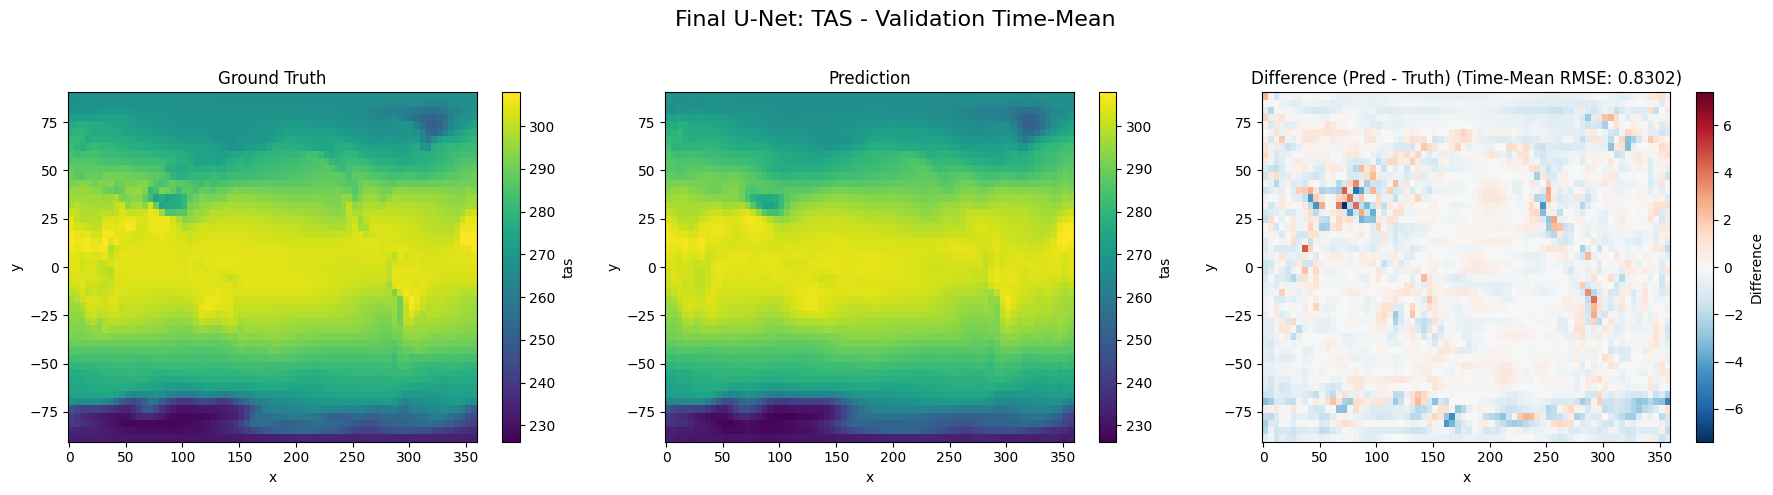

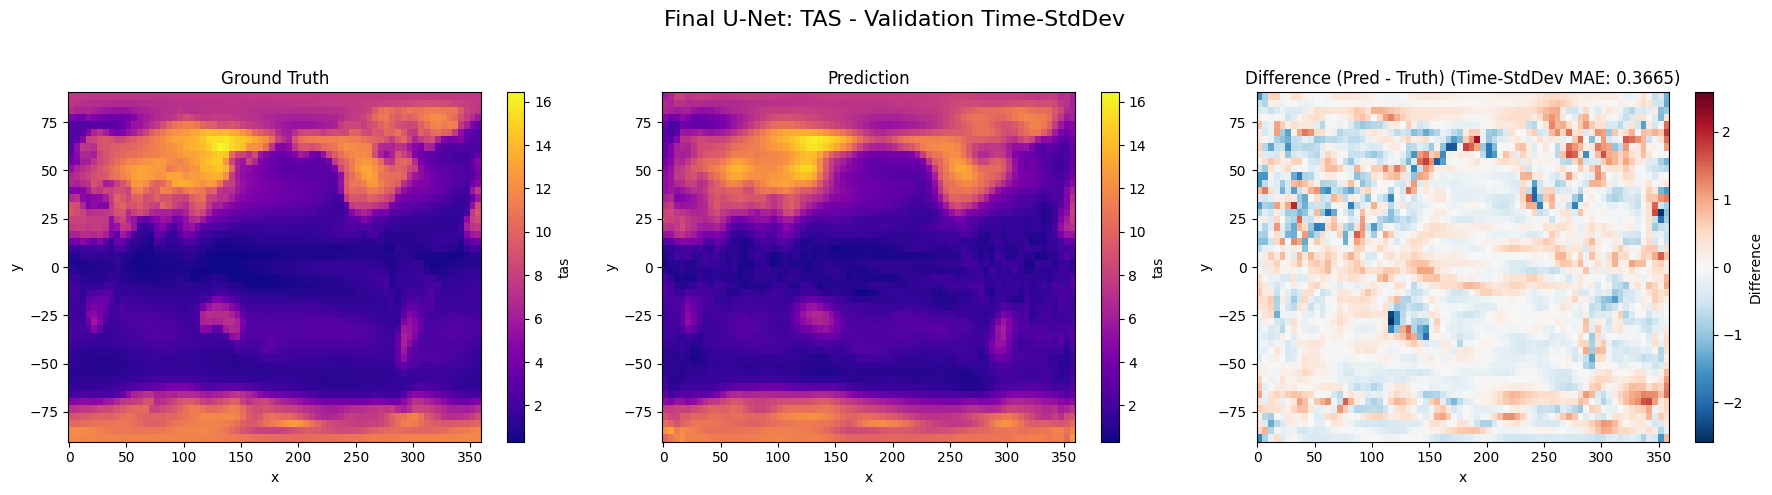

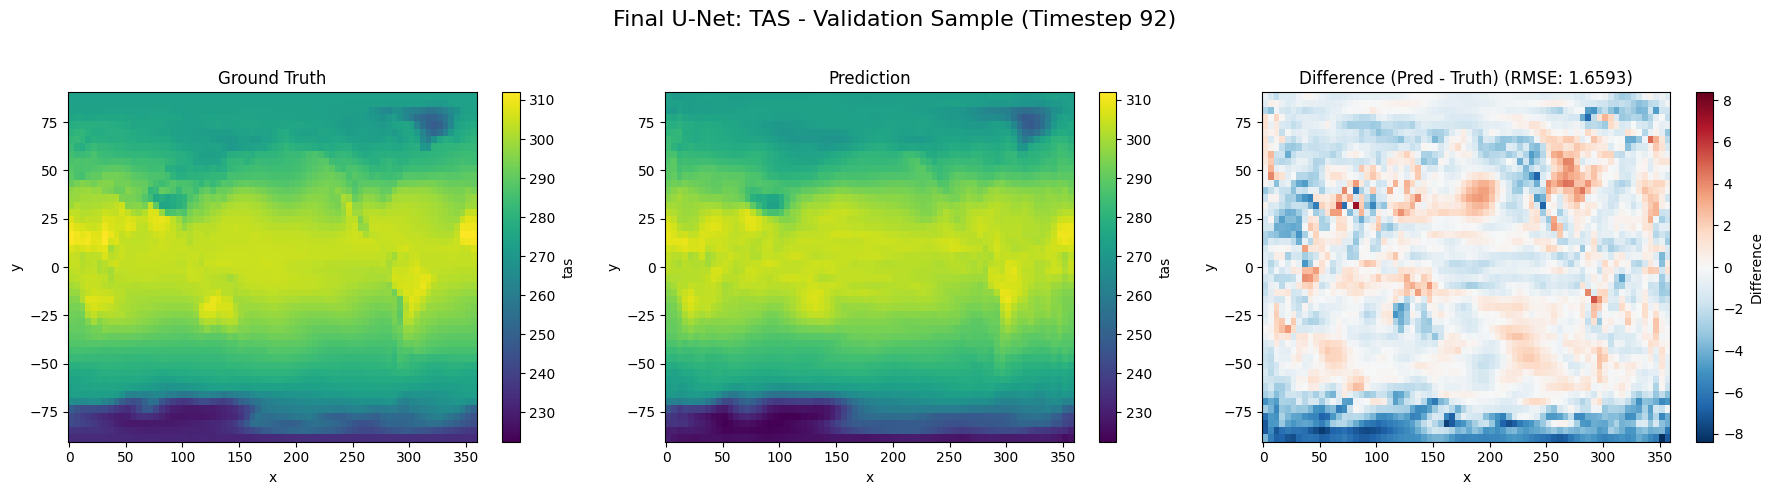

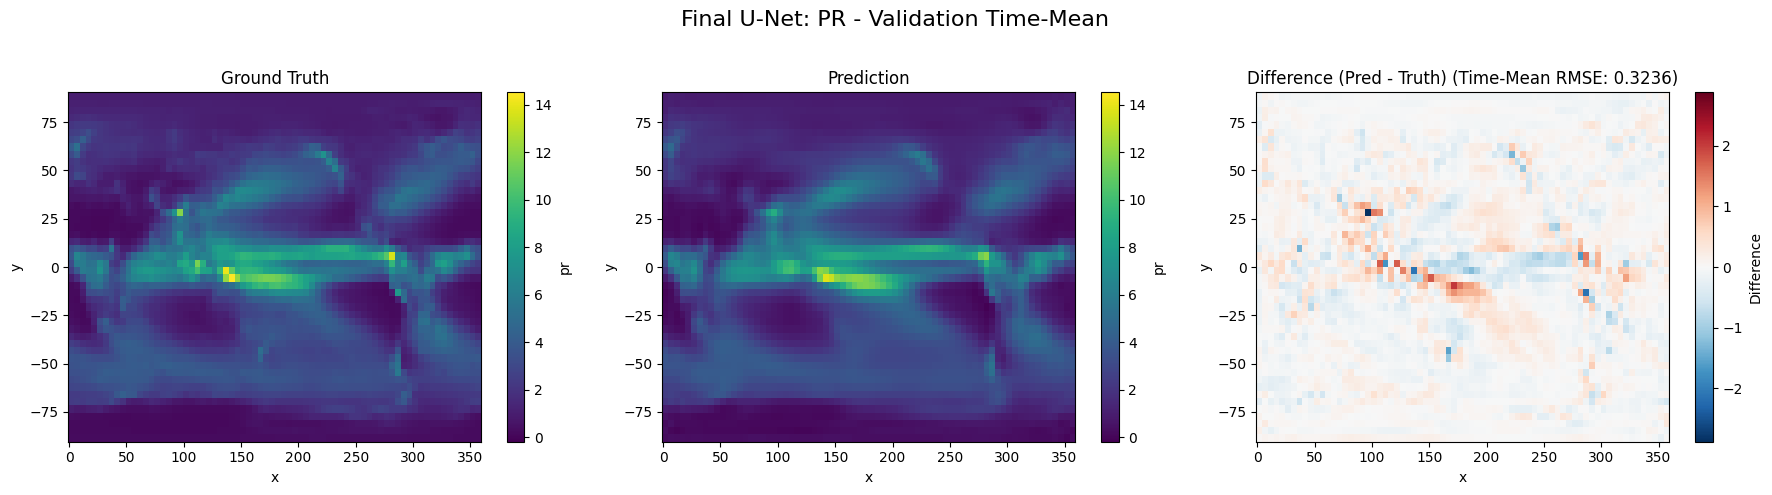

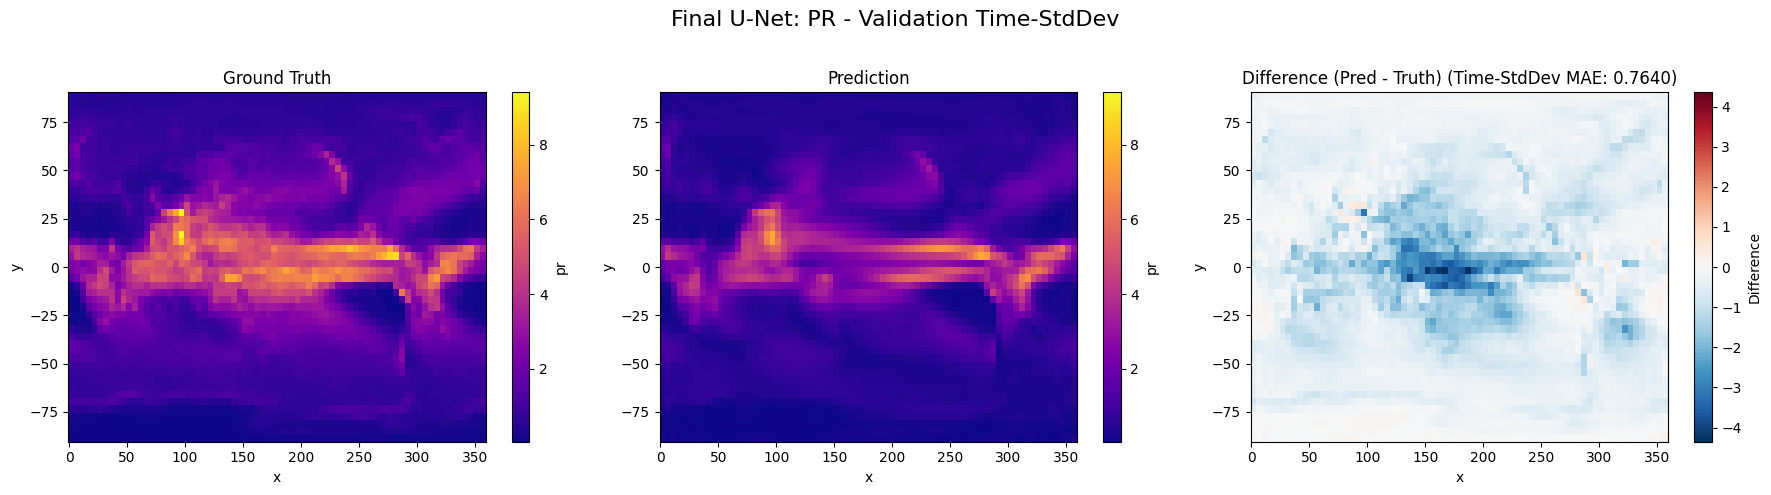

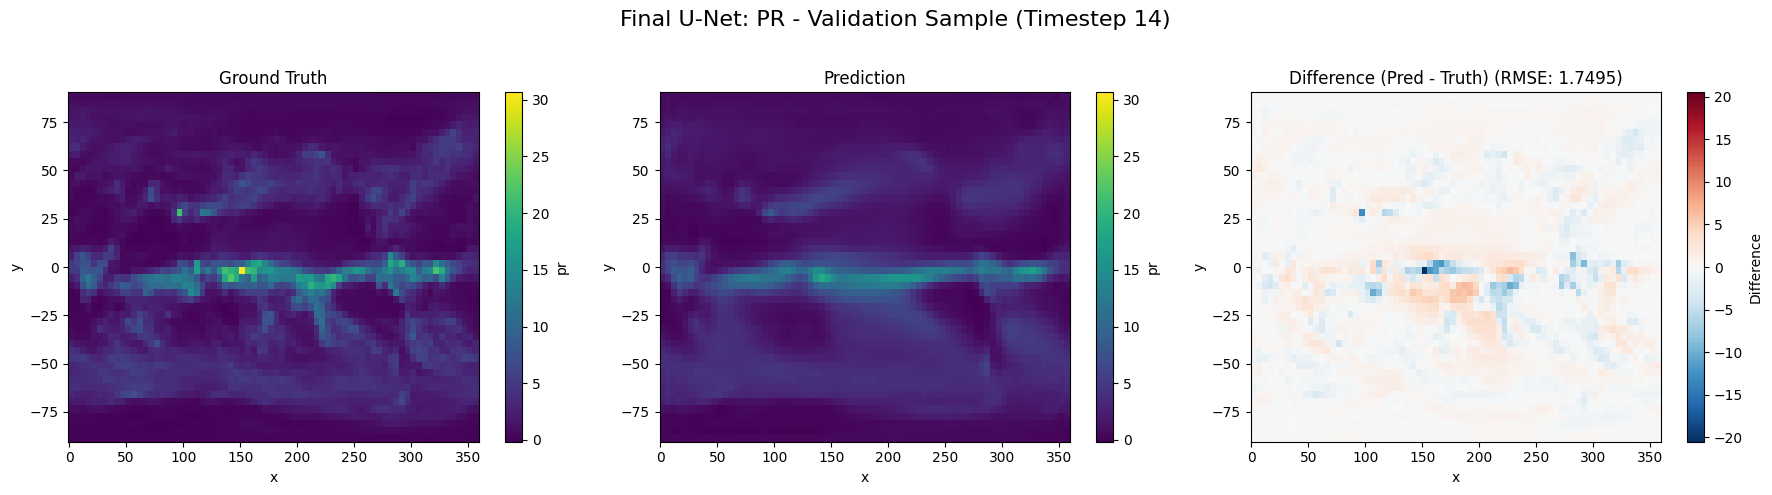

In [14]:
# Cell 13: U-Net - Final Visualization
# This cell loads the validation predictions saved during the FINAL U-Net training run and plots them.

print(f"\n--- Visualizing Validation Predictions for Final U-Net ---")
try:
    # Load the saved predictions and true values from the final U-Net run
    val_preds_loaded_final_unet = np.load("val_preds.npy") 
    val_trues_loaded_final_unet = np.load("val_trues.npy")

    # Ensure datamodule_final_unet is available from the training cell (Cell 18)
    if 'datamodule_final_unet' not in globals() or not hasattr(datamodule_final_unet, 'lat') or datamodule_final_unet.lat is None:
        print("datamodule_final_unet not fully set up for visualization. Setting it up...")
        datamodule_final_unet_viz = ClimateDataModule(**config["data"]) # Use global config for safety
        datamodule_final_unet_viz.setup(stage="fit") 
        lat, lon = datamodule_final_unet_viz.get_coords()
        output_vars = config["data"]["output_vars"] 
        area_weights_vis = datamodule_final_unet_viz.get_lat_weights()
    else:
        lat, lon = datamodule_final_unet.get_coords()
        output_vars = config["data"]["output_vars"] 
        area_weights_vis = datamodule_final_unet.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded_final_unet.shape[0])

    for i, var_name in enumerate(output_vars):
        pred_xr_final_unet = xr.DataArray(val_preds_loaded_final_unet[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr_final_unet = xr.DataArray(val_trues_loaded_final_unet[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean_final_unet = pred_xr_final_unet.mean("time")
        true_mean_final_unet = true_xr_final_unet.mean("time")
        mean_rmse_var_final_unet = np.sqrt(((pred_mean_final_unet - true_mean_final_unet) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean_final_unet, pred_mean_final_unet, 
                        f"Final U-Net: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var_final_unet, metric_name="Time-Mean RMSE")

        pred_std_final_unet = pred_xr_final_unet.std("time")
        true_std_final_unet = true_xr_final_unet.std("time")
        std_mae_var_final_unet = np.abs(pred_std_final_unet - true_std_final_unet).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std_final_unet, pred_std_final_unet, 
                        f"Final U-Net: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var_final_unet, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random_final_unet = np.random.randint(0, len(time_val_coords))
            pred_sample_final_unet = pred_xr_final_unet.isel(time=t_idx_random_final_unet)
            true_sample_final_unet = true_xr_final_unet.isel(time=t_idx_random_final_unet)
            sample_rmse_var_final_unet = np.sqrt(((pred_sample_final_unet - true_sample_final_unet) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample_final_unet, pred_sample_final_unet, 
                            f"Final U-Net: {var_name.upper()} - Validation Sample (Timestep {t_idx_random_final_unet})",
                            metric_val=sample_rmse_var_final_unet, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except NameError as e:
    print(f"NameError during U-Net final visualization: {e}. Ensure 'best_run_unet' was defined and the final training cell (Cell 18) ran successfully.")
except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found for final U-Net run. "
          "Ensure that the final U-Net training and validation (Cell 18) has run successfully.")
except AttributeError as e:
    print(f"AttributeError during final U-Net visualization: {e}. Ensure datamodule_final_unet is correctly initialized.")
except Exception as e:
    print(f"An error occurred during final U-Net visualization: {e}")
